In [16]:
!splitcode --version
!kallisto version
!fastq-dump --version

splitcode, version 0.30.0
kallisto, version 0.51.1

fastq-dump : 3.2.1



In [18]:
# Found at https://www.ncbi.nlm.nih.gov/sra?term=SRX23254918
# Retrieve SRA Parse Data
!fastq-dump --outdir FASTA --gzip --skip-technical  --readids --dumpbase --split-files --clip --read-filter pass SRR27585877

Read 23911321 spots for SRR27585877
Written 23911321 spots for SRR27585877


In [19]:
# Change names of file so easier to read
!mv FASTA/SRR27585877_pass_1.fastq.gz FASTA/raw_Parse_9_R1.fastq.gz
!mv FASTA/SRR27585877_pass_2.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz

In [3]:
# Extract all reads
!splitcode -c parse_extraction/config_correct.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_9_R1.fastq.gz,FASTA/Parse_9_R2.fastq.gz \
    --outb=FASTA/barcodes/parse_barcodes.fastq --mapping=run_info/parse_mapping.txt --summary=run_info/parse_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 384 tags (vector size: 384; map size: 8,858; num elements in map: 12,672)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
21M reads processed (84.2% assigned)
done 
* processed 23,911,321 reads, 20,098,558 reads were assigned


In [22]:
# Divide the reads into different wells
! mkdir FASTA/wells
n = 0

with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" +  "FASTA/wells/well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" +  "FASTA/wells/well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1,78,86" + "\t\t" + "1" + "\n")

In [23]:
!splitcode --gzip --keep-r1-r2 --keep=parse_extraction/keep_wells.txt -c parse_extraction/config_wells.txt \
    --nFastqs=2 --no-output --no-outb \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
3M reads processed         

In [10]:
# Extract polyT reads
!splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_polyT_9_R1.fastq.gz,FASTA/Parse_polyT_9_R2.fastq.gz \
    --outb=FASTA/barcodes/polyT_barcodes.fastq --mapping=run_info/polyT_mapping.txt --summary=run_info/polyT_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 288 tags (vector size: 288; map size: 6,072; num elements in map: 9,504)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
* processing the reads ...^C


In [33]:
# Extract randO reads
!splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
    --assign -o FASTA/Parse_randO_9_R1.fastq.gz,FASTA/Parse_randO_9_R2.fastq.gz \
    --outb=FASTA/barcodes/randO_barcodes.fastq --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
    FASTA/raw_Parse_9_R1.fastq.gz FASTA/raw_Parse_9_R2.fastq.gz -t 2

* Using a list of 288 tags (vector size: 288; map size: 6,079; num elements in map: 9,504)
* will process sample 1: FASTA/raw_Parse_9_R1.fastq.gz
                         FASTA/raw_Parse_9_R2.fastq.gz
21M reads processed (44.1% assigned)
done 
* processed 23,911,321 reads, 10,540,049 reads were assigned


In [34]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref -d mouse -i index.idx -g t2g.txt

[2025-07-08 12:55:48,138]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz to tmp/mouse_index_standard.tar.xz
100%|██████████████████████████████████████| 82.8M/82.8M [00:04<00:00, 17.7MB/s]
[2025-07-08 12:55:53,070]    INFO [download] Extracting files from tmp/mouse_index_standard.tar.xz


In [2]:
# Perform pseudoalignment of polyT reads
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o polyT_out FASTA/Parse_polyT_9_R1.fastq.gz FASTA/Parse_polyT_9_R2.fastq.gz

[2025-07-13 22:11:13,129]    INFO [count] Using index index.idx to generate BUS file to polyT_out from
[2025-07-13 22:11:13,129]    INFO [count]         FASTA/Parse_polyT_9_R1.fastq.gz
[2025-07-13 22:11:13,129]    INFO [count]         FASTA/Parse_polyT_9_R2.fastq.gz
[2025-07-13 22:13:23,199]    INFO [count] Sorting BUS file polyT_out/output.bus to polyT_out/tmp/output.s.bus
[2025-07-13 22:13:25,560]    INFO [count] On-list not provided
[2025-07-13 22:13:25,560]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to polyT_out
[2025-07-13 22:13:25,587]    INFO [count] Inspecting BUS file polyT_out/tmp/output.s.bus
[2025-07-13 22:13:26,942]    INFO [count] Correcting BUS records in polyT_out/tmp/output.s.bus to polyT_out/tmp/output.s.c.bus with on-list polyT_out/splitseq_version2_whitelist.txt
[2025-07-13 22:13:28,159]    INFO [count] Sorting BUS file polyT_out/tmp/output.s.c.bus to polyT_out/output.unfiltered.bus
[2025-07-13 22:13:30,517]    INFO [count] Generating count matrix polyT_

In [44]:
# Perform pseudoalignment of randO reads
!kb count --overwrite --h5ad --strand forward -w onlist.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o randO_out FASTA/Parse_randO_9_R1.fastq.gz FASTA/Parse_randO_9_R2.fastq.gz

[2025-07-08 13:19:40,146]    INFO [count] Using index index.idx to generate BUS file to randO_out from
[2025-07-08 13:19:40,147]    INFO [count]         FASTA/Parse_randO_9_R1.fastq.gz
[2025-07-08 13:19:40,147]    INFO [count]         FASTA/Parse_randO_9_R2.fastq.gz
[2025-07-08 13:21:26,263]    INFO [count] Sorting BUS file randO_out/output.bus to randO_out/tmp/output.s.bus
[2025-07-08 13:21:29,112]    INFO [count] Inspecting BUS file randO_out/tmp/output.s.bus
[2025-07-08 13:21:30,445]    INFO [count] Correcting BUS records in randO_out/tmp/output.s.bus to randO_out/tmp/output.s.c.bus with on-list onlist.txt
[2025-07-08 13:21:31,670]    INFO [count] Sorting BUS file randO_out/tmp/output.s.c.bus to randO_out/output.unfiltered.bus
[2025-07-08 13:21:34,036]    INFO [count] Generating count matrix randO_out/counts_unfiltered/cells_x_genes from BUS file randO_out/output.unfiltered.bus
[2025-07-08 13:21:36,041]    INFO [count] Writing gene names to file randO_out/counts_unfiltered/cells_x_g

In [1]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import mygene
import pandas as pd

In [2]:
raw_polyT_data = anndata.read_h5ad('polyT_out/counts_unfiltered/adata.h5ad')
raw_randO_data = anndata.read_h5ad('randO_out/counts_unfiltered/adata.h5ad')

# Parse PolyT Read Analysis

In [3]:
#read in polyT_gene names

raw_polyT_data.var["gene_codes"] = raw_polyT_data.var.index.tolist()

polyT_gene_names = []

with open('polyT_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
    for line in file:
        polyT_gene_names.append(line.strip())

raw_polyT_data.var_names = polyT_gene_names

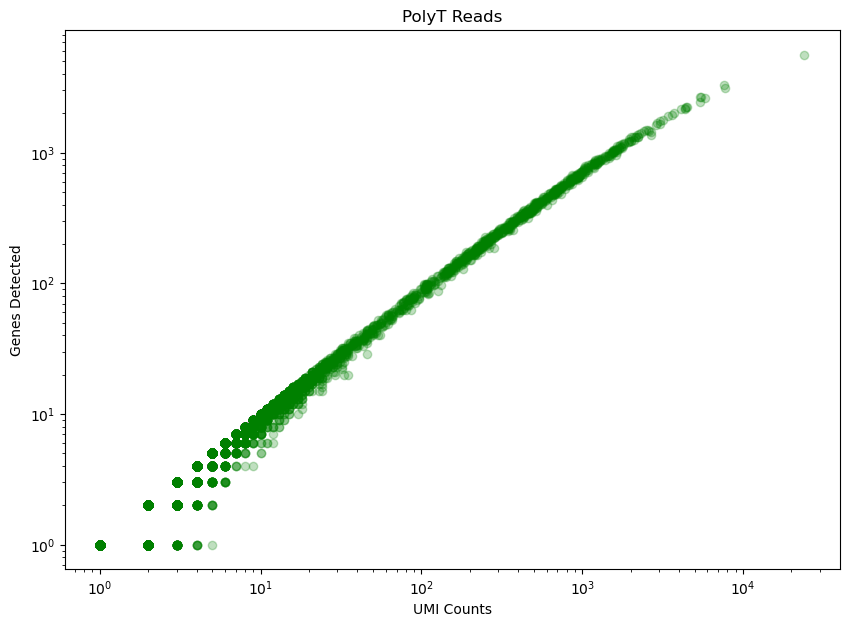

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(raw_polyT_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(raw_polyT_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

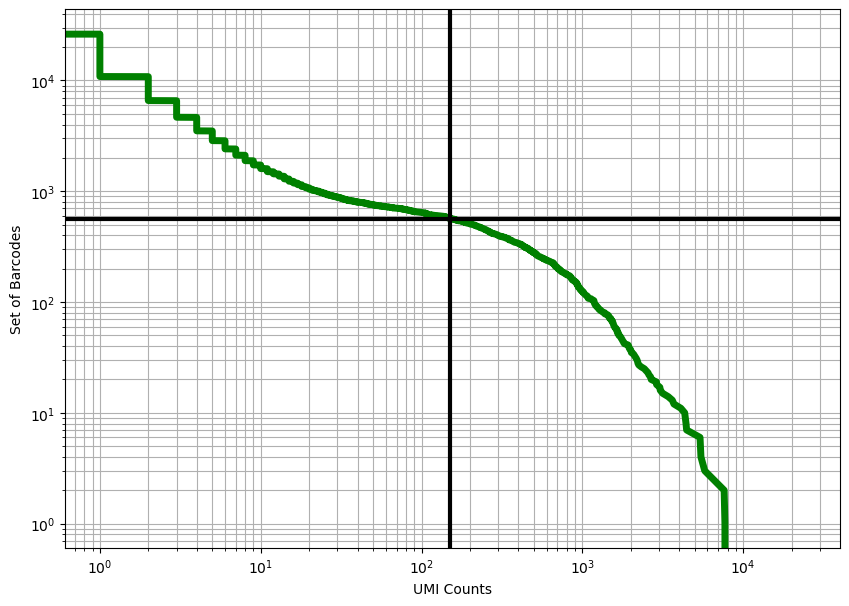

In [5]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 150  #@param {type:"integer"}
knee = np.sort((np.array(raw_polyT_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [6]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

567 cells passed the 150 UMI threshold


In [50]:
mg = mygene.MyGeneInfo()

# Query Ensembl for gene biotypes
gene_info = mg.querymany(polyT_gene_names, scopes='symbols', fields='type_of_gene', species='mouse')


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [8]:
# Identify ncRNA genes
raw_polyT_data.var["is_nc"] = np.full(len(raw_polyT_data.var_names), False)
nc_genes = gene_df[gene_df['type_of_gene'] == 'ncRNA']["query"].tolist()
raw_polyT_data.var.loc[nc_genes, ["is_nc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
raw_polyT_data.var["is_mito"] = raw_polyT_data.var_names.str.startswith("Mt")
# ribosomal genes
raw_polyT_data.var["is_ribo"] = raw_polyT_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = raw_polyT_data[:, raw_polyT_data.var['is_mito']].X.sum(axis=1)
ribo_counts = raw_polyT_data[:, raw_polyT_data.var['is_ribo']].X.sum(axis=1)
nc_counts = raw_polyT_data[:, raw_polyT_data.var['is_nc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = raw_polyT_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
raw_polyT_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
raw_polyT_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
raw_polyT_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()

raw_polyT_data.obs['n_counts'] = raw_polyT_data.X.sum(axis=1).A1

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1774326183.py:19: RuntimeWarning: invalid value encountered in divide
  raw_polyT_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1774326183.py:20: RuntimeWarning: invalid value encountered in divide
  raw_polyT_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1774326183.py:21: RuntimeWarning: invalid value encountered in divide
  raw_polyT_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()


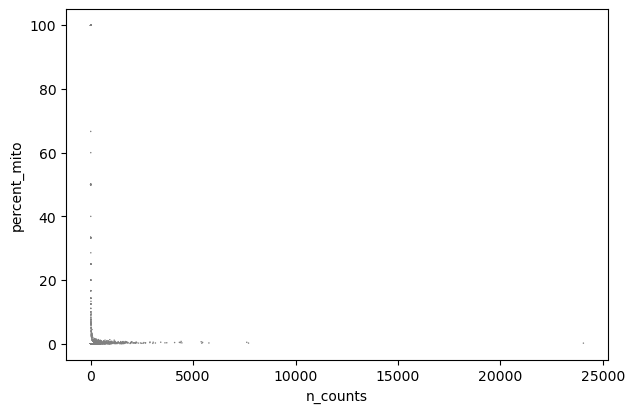

In [9]:
sc.pl.scatter(raw_polyT_data, x='n_counts', y='percent_mito')

In [10]:
polyT_data = raw_polyT_data[raw_polyT_data.obs.percent_mito < 30]
sc.pp.filter_cells(polyT_data, min_genes=200)
sc.pp.filter_cells(polyT_data, min_counts=knee[num_cells])
sc.pp.filter_genes(polyT_data, min_cells=3)

/opt/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


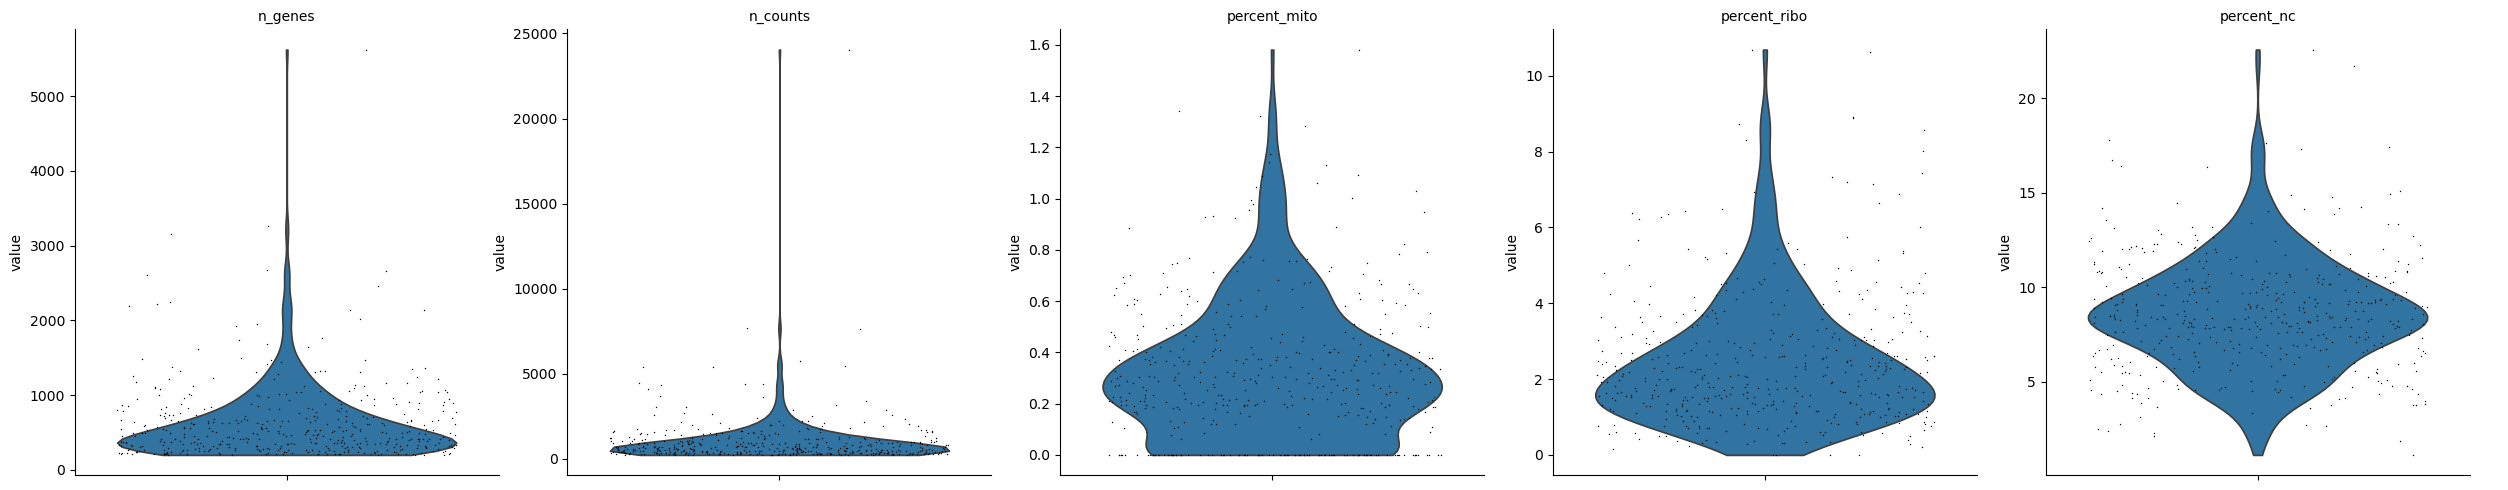

In [11]:
sc.pl.violin(polyT_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_nc'], jitter=0.4, multi_panel=True)


In [12]:
polyT_data.write('processed_parse.h5ad', compression="gzip")

In [13]:
genes = polyT_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(polyT_data[:,gene].X.toarray().transpose()[0] / np.array(polyT_data.obs['n_counts'].tolist()))

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/2484750936.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)


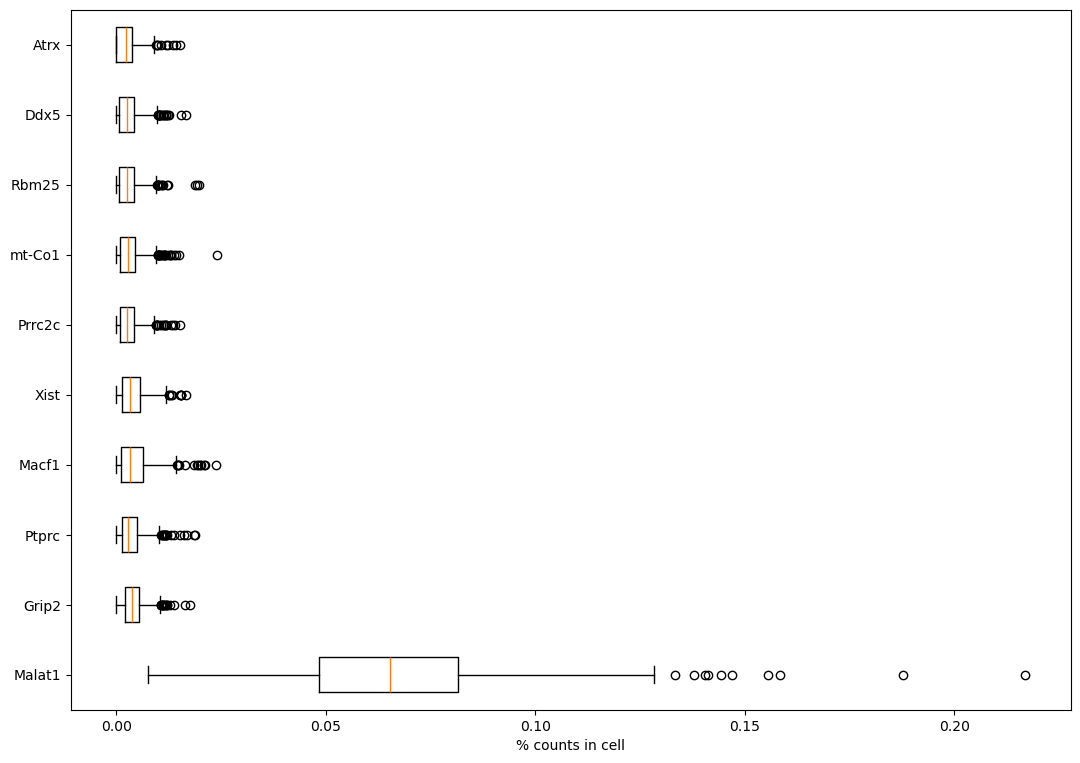

In [14]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)
ax.set_xlabel("% counts in cell")
plt.show()

# Parse RandO Read Analysis

In [15]:
#read in randO_gene names

raw_randO_data.var["gene_codes"] = raw_randO_data.var.index.tolist()

randO_gene_names = []

with open('randO_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
    for line in file:
        randO_gene_names.append(line.strip())

raw_randO_data.var_names = randO_gene_names

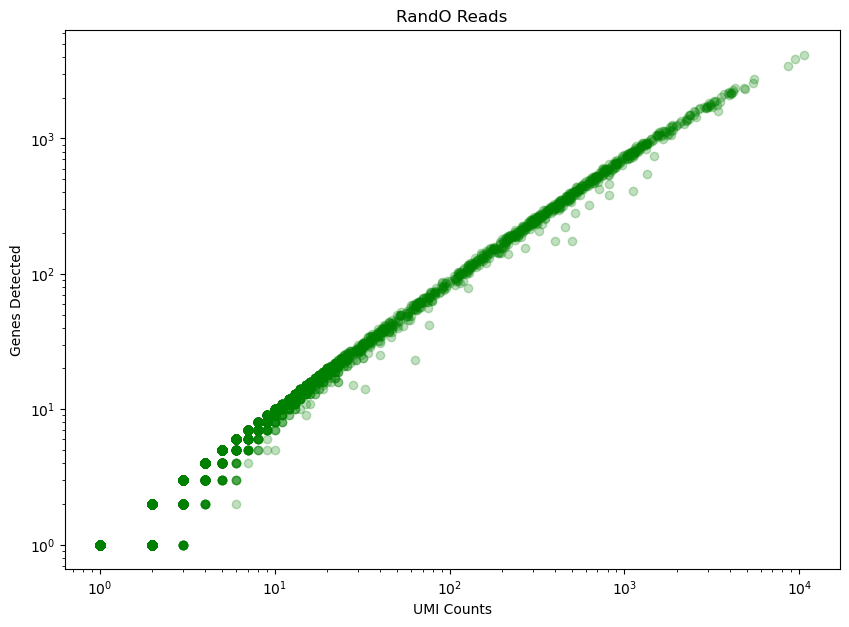

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(raw_randO_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(raw_randO_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("RandO Reads")

plt.show()

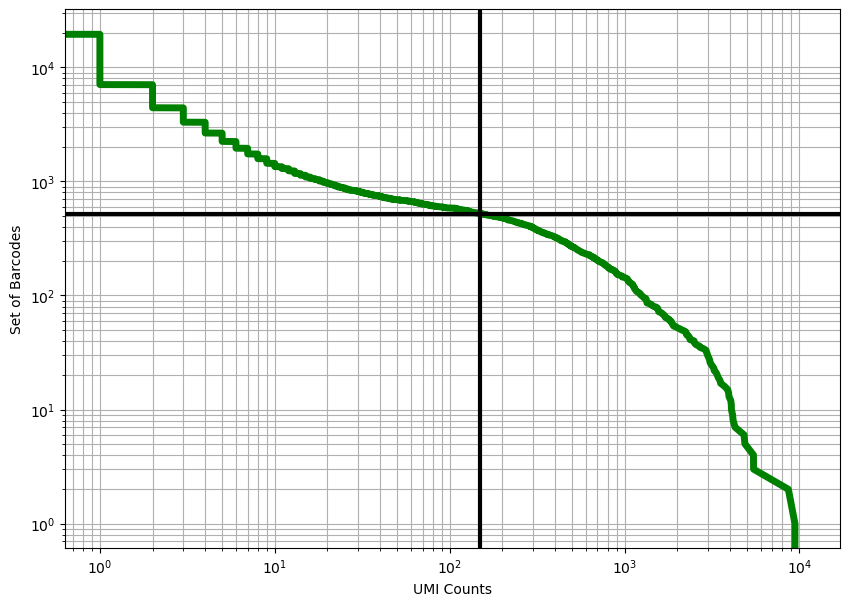

In [17]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 150  #@param {type:"integer"}
knee = np.sort((np.array(raw_randO_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [18]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

523 cells passed the 150 UMI threshold


In [19]:
mg = mygene.MyGeneInfo()

# Query Ensembl for gene biotypes
gene_info = mg.querymany(randO_gene_names, scopes='symbol', fields='type_of_gene', species='mouse')
gene_df = pd.DataFrame(gene_info)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
3406 input query terms found dup hits:	[('Gm29155', 2), ('C730036E19Rik', 2), ('Gm26901', 2), ('Gm30414', 2), ('9330185C12Rik', 2), ('Rbm8a
3745 input query terms found no hit:	['Gm7145', 'Gm8251', '1700016C15Rik', 'Adss', 'Gm29125', 'Gm28513', 'Gm29291', 'Gm28286', 'Gm9747', 


In [30]:
# Identify ncRNA genes
raw_randO_data.var["is_nc"] = np.full(len(raw_randO_data.var_names), False)
nc_genes = gene_df[gene_df['type_of_gene'] == 'ncRNA']["query"].tolist()
raw_randO_data.var.loc[nc_genes, ["is_nc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
raw_randO_data.var["is_mito"] = raw_randO_data.var_names.str.startswith("Mt")
# ribosomal genes
raw_randO_data.var["is_ribo"] = raw_randO_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = raw_randO_data[:, raw_randO_data.var['is_mito']].X.sum(axis=1)
ribo_counts = raw_randO_data[:, raw_randO_data.var['is_ribo']].X.sum(axis=1)
nc_counts = raw_randO_data[:, raw_randO_data.var['is_nc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = raw_randO_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
raw_randO_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
raw_randO_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
raw_randO_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()

raw_randO_data.obs['n_counts'] = raw_randO_data.X.sum(axis=1).A1

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1485428143.py:19: RuntimeWarning: invalid value encountered in divide
  raw_randO_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1485428143.py:20: RuntimeWarning: invalid value encountered in divide
  raw_randO_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/1485428143.py:21: RuntimeWarning: invalid value encountered in divide
  raw_randO_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()


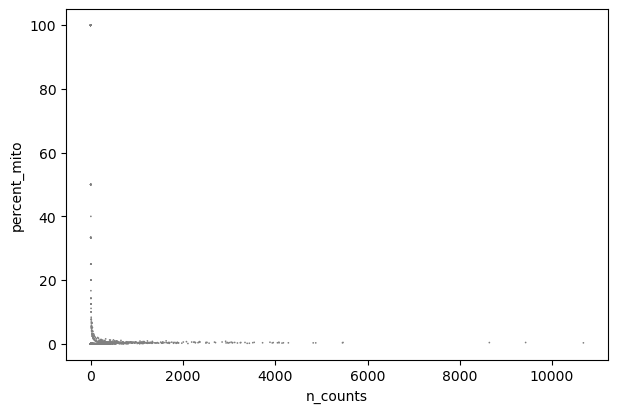

In [21]:
sc.pl.scatter(raw_randO_data, x='n_counts', y='percent_mito')

In [28]:
randO_data = raw_randO_data[raw_randO_data.obs.percent_mito < 30]
sc.pp.filter_cells(randO_data, min_genes=200)
sc.pp.filter_cells(randO_data, min_counts=knee[num_cells])
sc.pp.filter_genes(randO_data, min_cells=3)

/opt/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


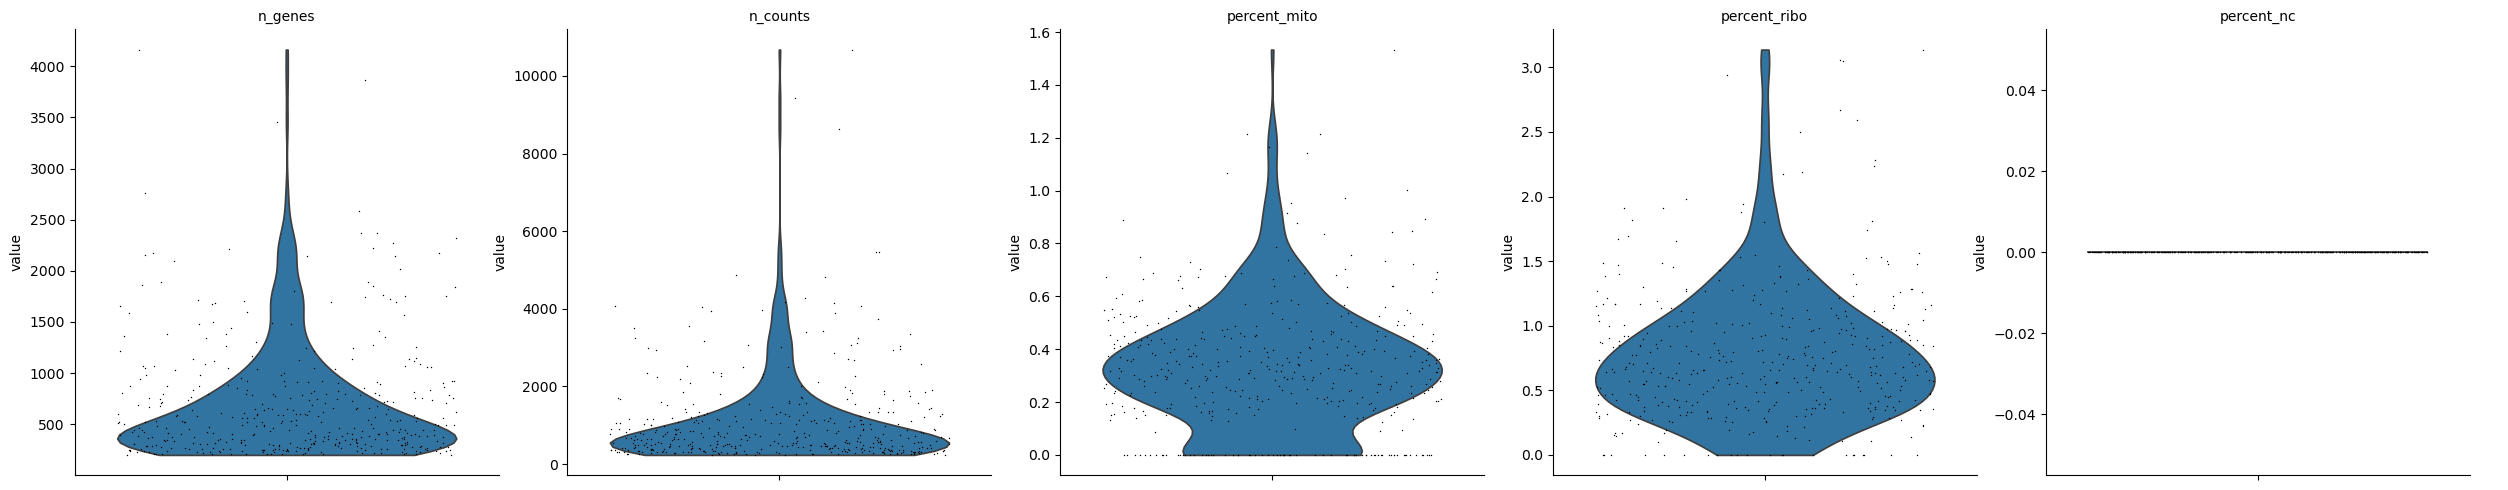

In [29]:
sc.pl.violin(randO_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_nc'], jitter=0.4, multi_panel=True)

In [25]:
genes = randO_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(randO_data[:,gene].X.toarray().transpose()[0] / np.array(randO_data.obs['n_counts'].tolist()))

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_29561/2484750936.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)


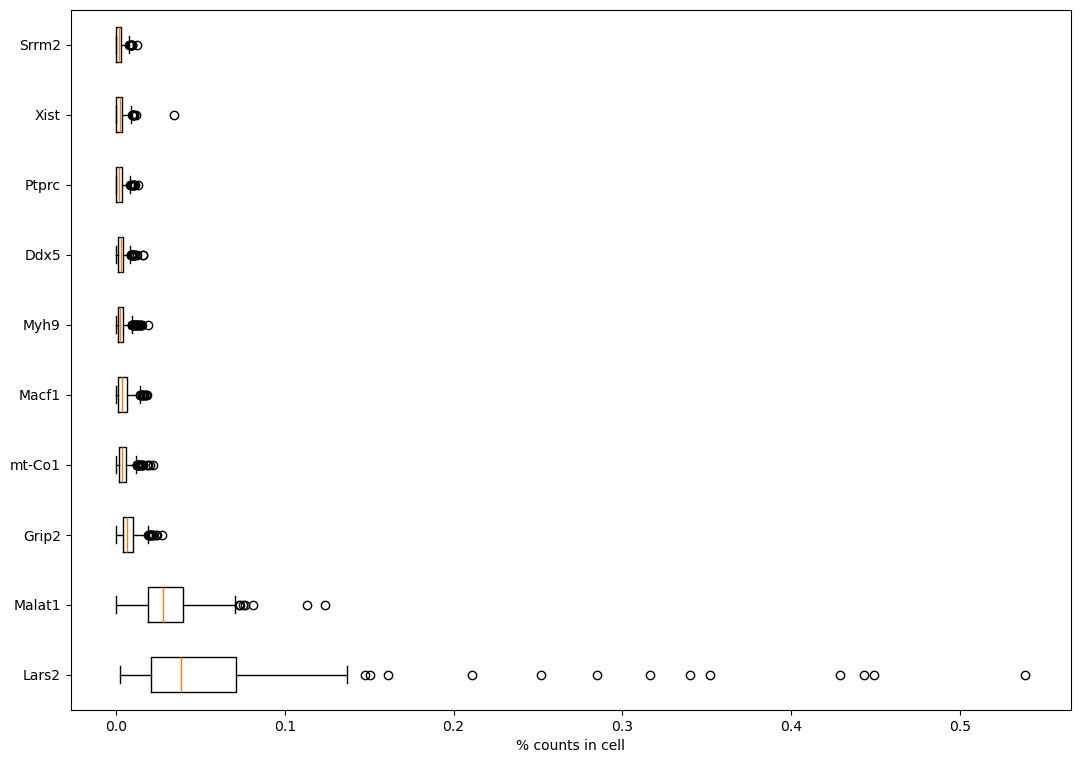

In [26]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)
ax.set_xlabel("% counts in cell")
plt.show()